# Jan ??th, 2021 (debug, misc)

**Motivation**: Debug  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Prepare

In [2]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}

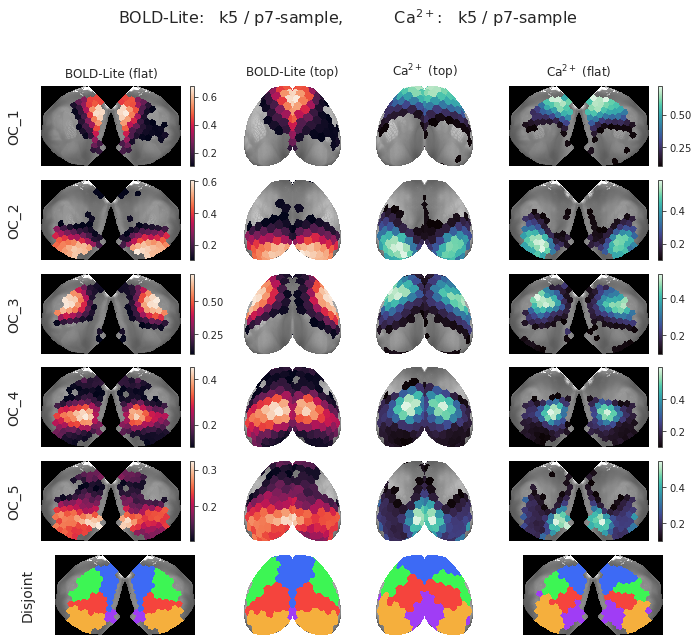

BOLD   : : :   ovp: 0.9939,  disj: 0.9770

Ca2    : : :   ovp: 0.9867,  disj: 0.9356

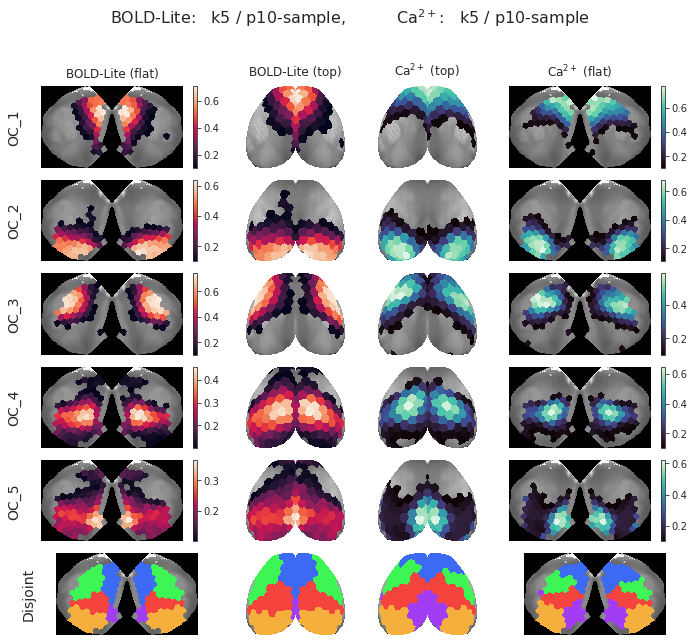

BOLD   : : :   ovp: 0.9943,  disj: 0.9816

Ca2    : : :   ovp: 0.9874,  disj: 0.9494

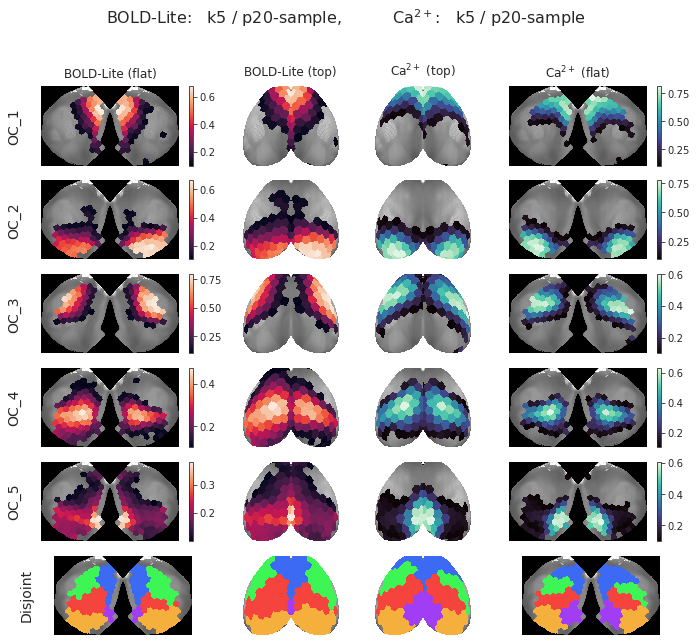

BOLD   : : :   ovp: 0.9863,  disj: 0.9448

Ca2    : : :   ovp: 0.9870,  disj: 0.9402

In [3]:
for perc in [7, 10, 20]:
    props_ca = {'perc': f'p{perc}-sample', **props_base}
    props_bold = {'perc': f'p{perc}-sample', **props_base}

    gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group()
    gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=gr_bold.grp_pi,
        XB=gr_ca.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    gr_bold.pi = gr_bold.grp_pi
    gr_ca.pi = gr_ca.grp_pi[ids]
        
    proj_bold = gr_bold.project_vec()
    proj_ca = gr_ca.project_vec()

    fig, _ = gr_ca.show(
        proj_bold, proj_ca,
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('rocket', 'mako'),
        min_thres=0.1,
        display=False,
    )
    sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)

    display(fig)
    
    ovp, disj = gr_bold.pi_symmetry_score(decimals=5)
    print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
    ovp, disj = gr_ca.pi_symmetry_score(decimals=5)
    print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

## Previous Debugs

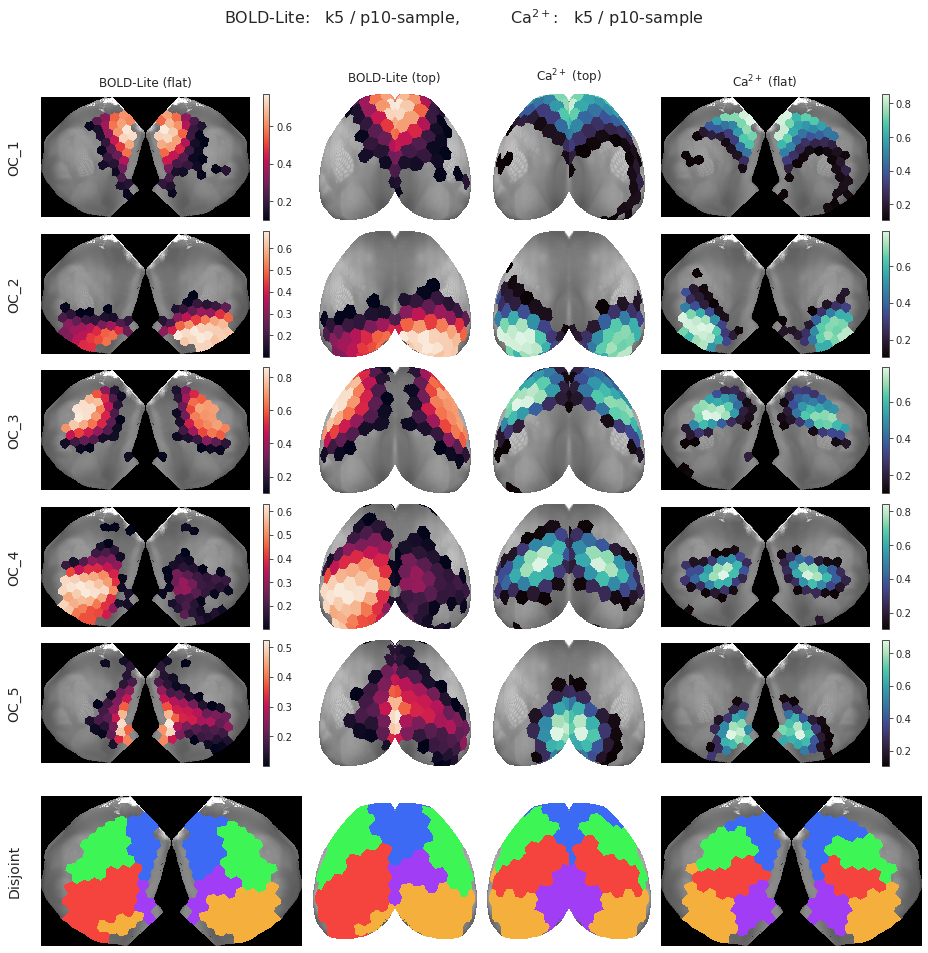

In [8]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

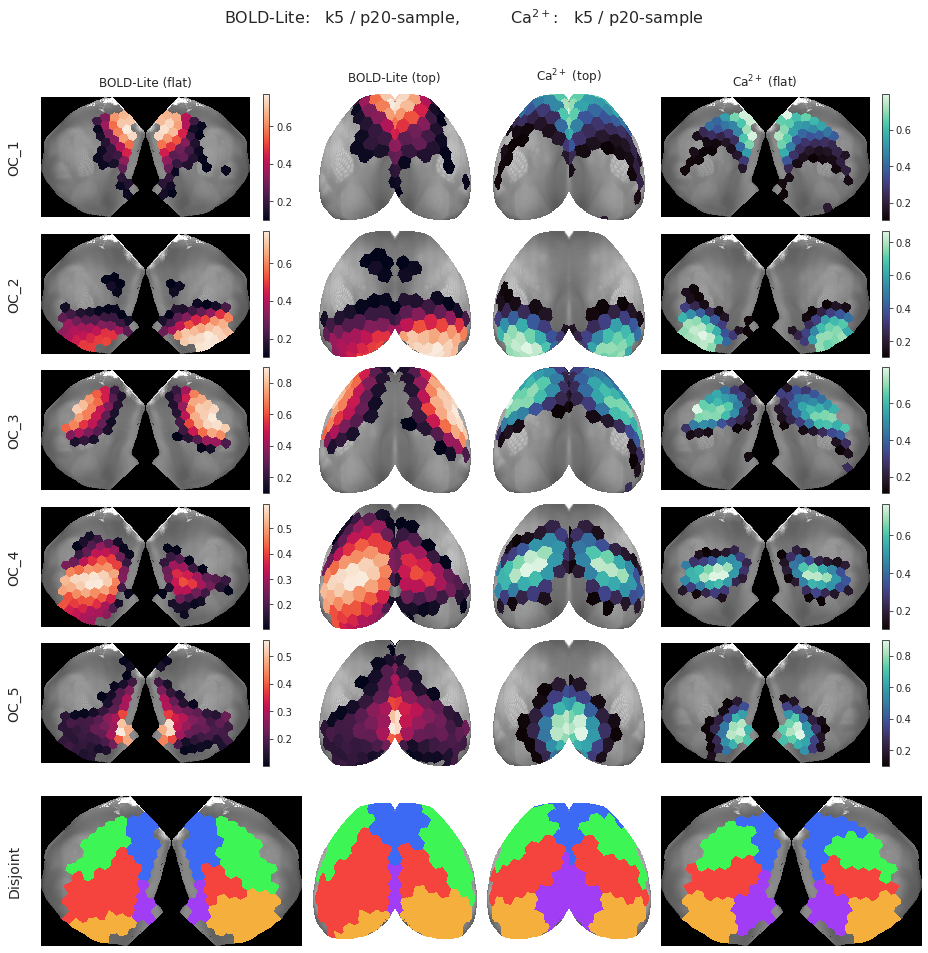

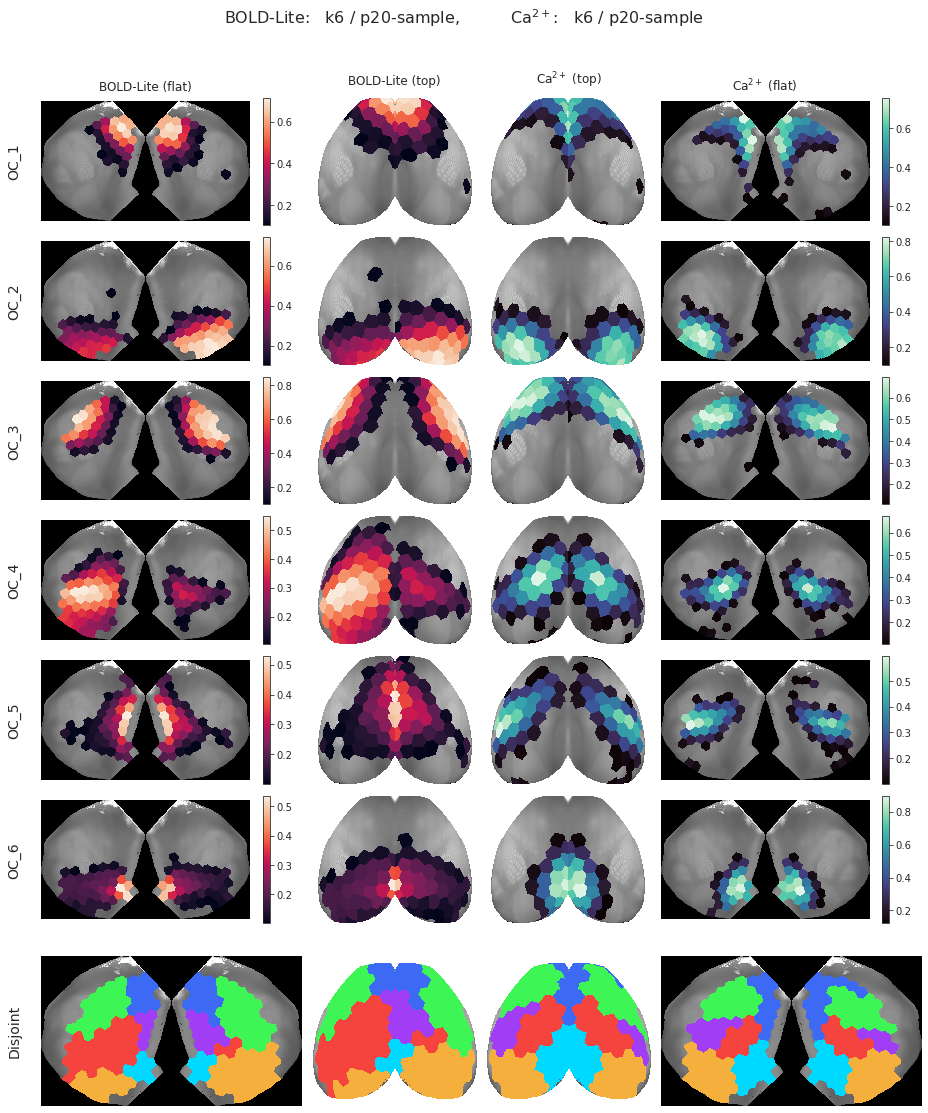

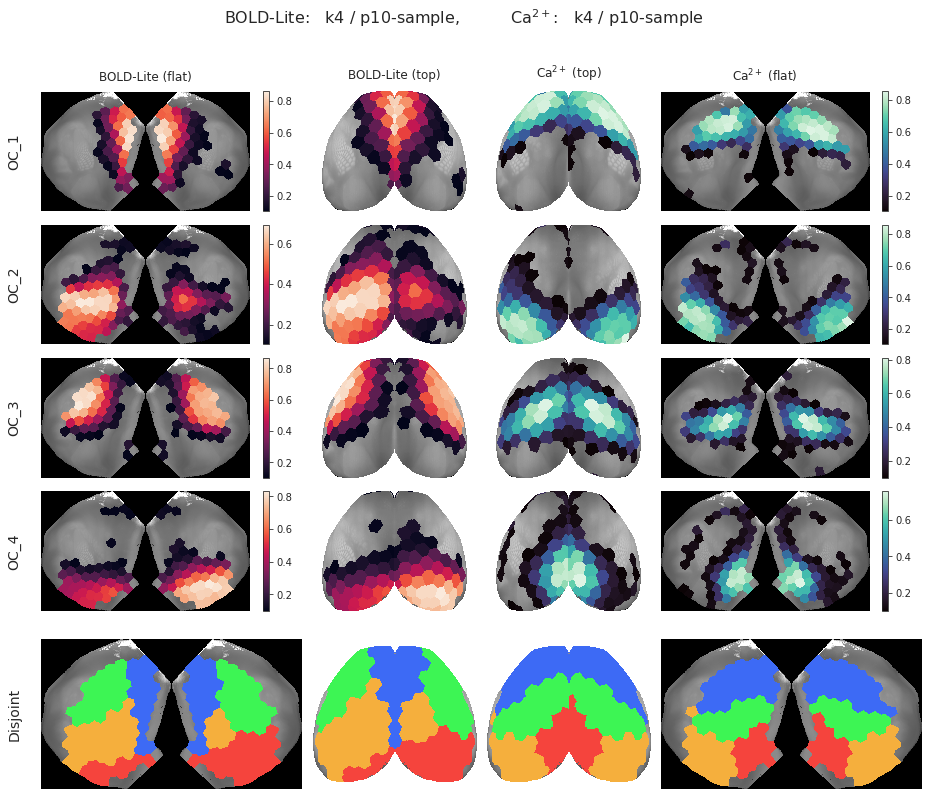

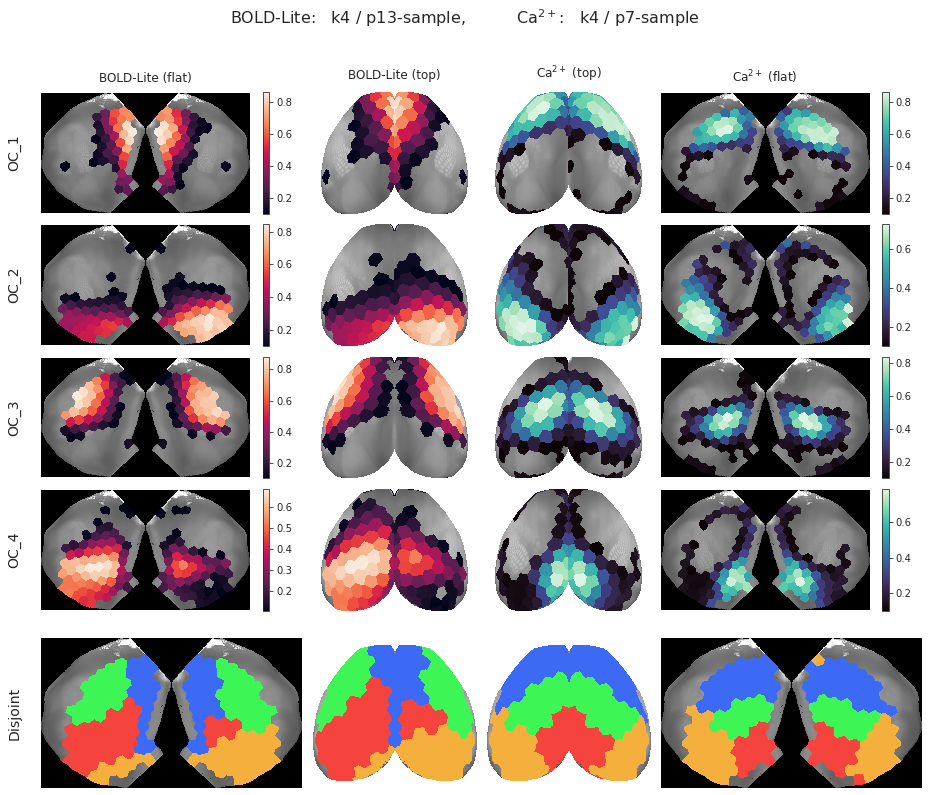

## Debug svinet

In [3]:
key = 'sub-SLC07_ses-2_run-5'
sv = SVINET(mice, num_k=4, key=key, perc='p13-sample', mode='bold-lite')

current expt: 'p13-sample'

In [4]:
sv.data

In [4]:
%%time

_ = sv.load_runs()
_ = sv.fit_svinet()

[PROGRESS] experiment loaded: 'k = 4, p13-sample',  total # runs:  500

[PROGRESS] fit: initiated

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

[PROGRESS] find best mappings: done

[PROGRESS] results aligned: done

[PROGRESS] align: done

[PROGRESS] 'gam.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'lam.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'pi.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'perms.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'gam_all.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'lam_all.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'pi_all.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] fit: done!

CPU times: user 9.08 s, sys: 546 ms, total: 9.62 s
Wall time: 3.65 s


In [5]:
sv.pi_symmetry_score()

{1: 0.91, 2: 0.59, 3: 0.9, 4: 0.6, -1: 0.75}

In [5]:
sv.pi_symmetry_score()

{1: 0.84, 2: 0.5, 3: 0.8, 4: 0.47, -1: 0.65}

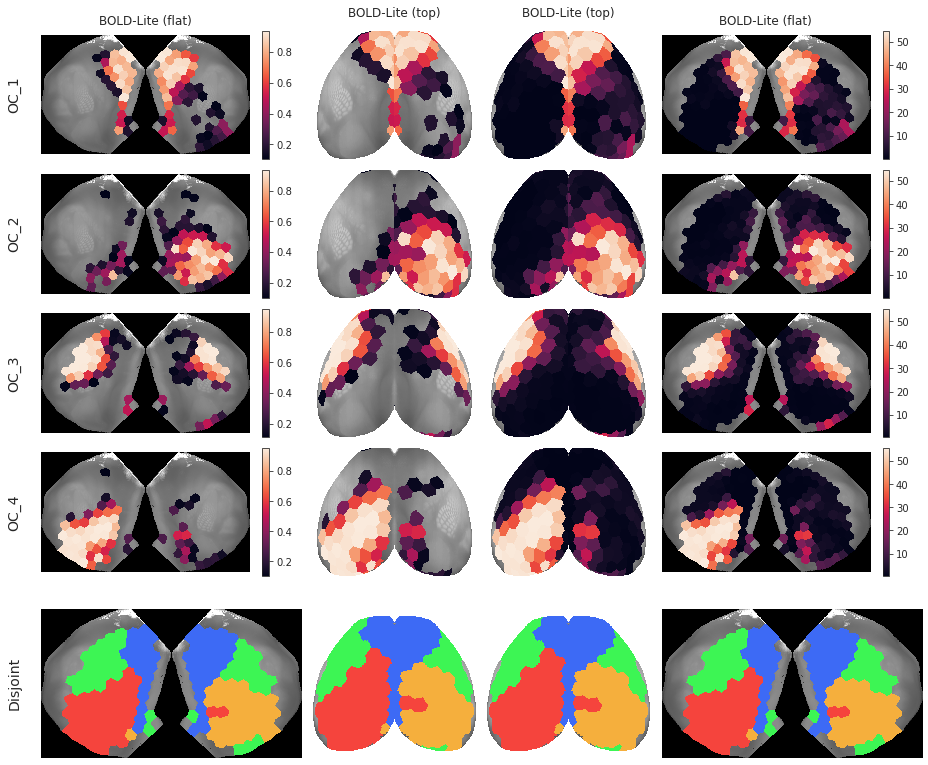

In [8]:
_ = sv.show(
    sv.project_vec(sv.pi),
    sv.project_vec(sv.gam),
    cmaps=('rocket', 'rocket'),
)

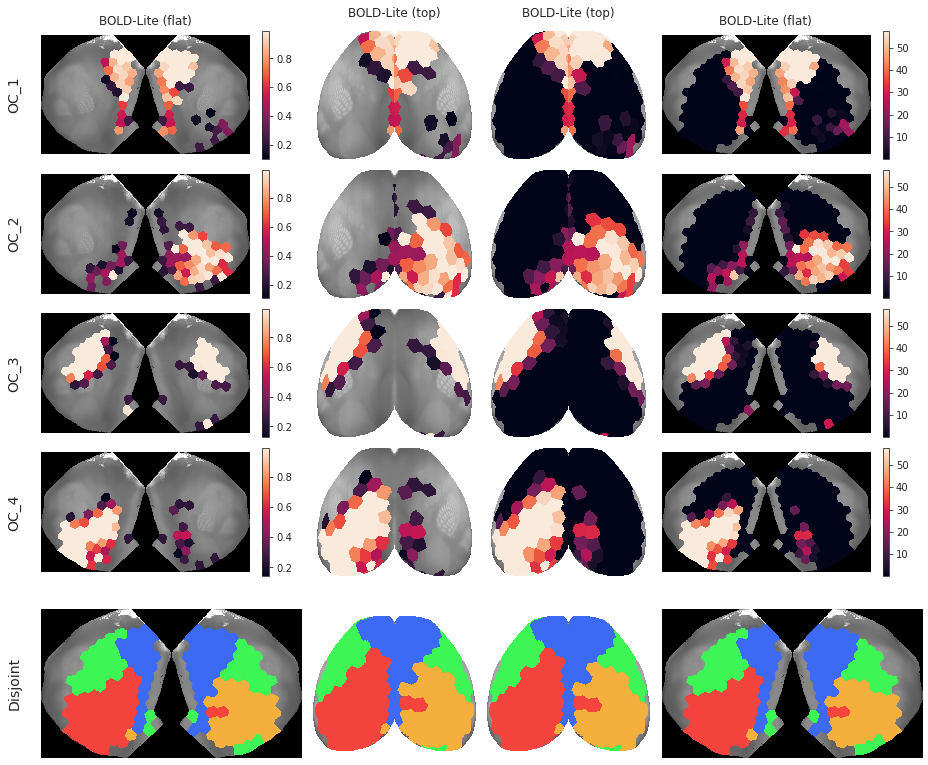

In [6]:
_ = sv.show(
    sv.project_vec(sv.pi),
    sv.project_vec(sv.gam),
    cmaps=('rocket', 'rocket'),
)

In [5]:
name = 'n168-k4-mmsb-seed15-linksampling'
run = sv._runs[sv.perc][name]
mapping = sv.perms[sv.perc][name]

In [6]:
list(run['partition_sv'].values()) == list(np.argmax(run['pi'], 0))

True

In [7]:
g1 = sv.gam_all[14]

In [8]:
g2 = run['gam'][[list(mapping.values())]]

In [9]:
c = 3
g1[:, c], g2[:, c]

(
    array([58.38109812,  0.17427196,  0.17427196,  0.17427196]),
    array([83.74999,  0.25   ,  0.25   ,  0.25   ])
)

In [10]:
0.25 / 0.17427196

1.4345394405387992

In [11]:
np.nansum(g1 * 1.4345394405387992 - g2)

-0.00036747015357707635

In [12]:
p1 = sv.pi_all[14]
p2 = run['pi'][[list(mapping.values())]]

In [13]:
c = 6
p1[:, c], p2[:, c]

(
    array([0.59522265, 0.00296201, 0.39874942, 0.00306592]),
    array([0.595, 0.003, 0.399, 0.003])
)

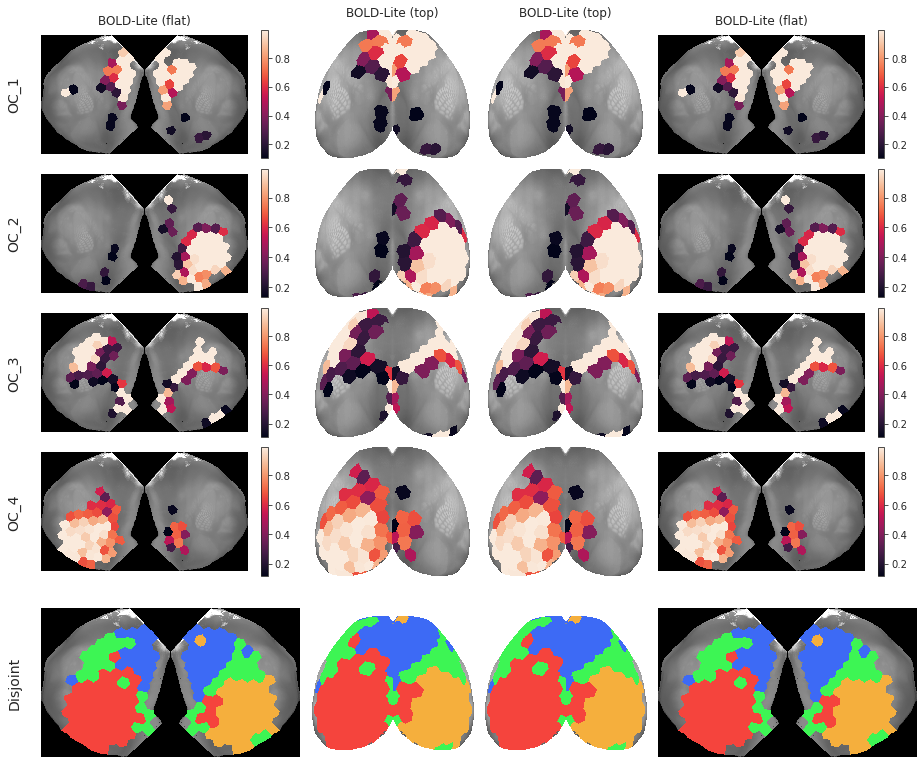

(
    <Figure size 936x792 with 28 Axes>,
    array([[<AxesSubplot:title={'center':'BOLD-Lite (flat)'}, ylabel='OC_1\n'>,
        <AxesSubplot:title={'center':'BOLD-Lite (top)'}>,
        <AxesSubplot:title={'center':'BOLD-Lite (top)'}>,
        <AxesSubplot:title={'center':'BOLD-Lite (flat)'}>],
       [<AxesSubplot:ylabel='OC_2\n'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='OC_3\n'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='OC_4\n'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Disjoint\n'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)
)

In [14]:
sv.show(
    sv.project_vec(p1),
    sv.project_vec(p2),
    cmaps=('rocket', 'rocket'),
)

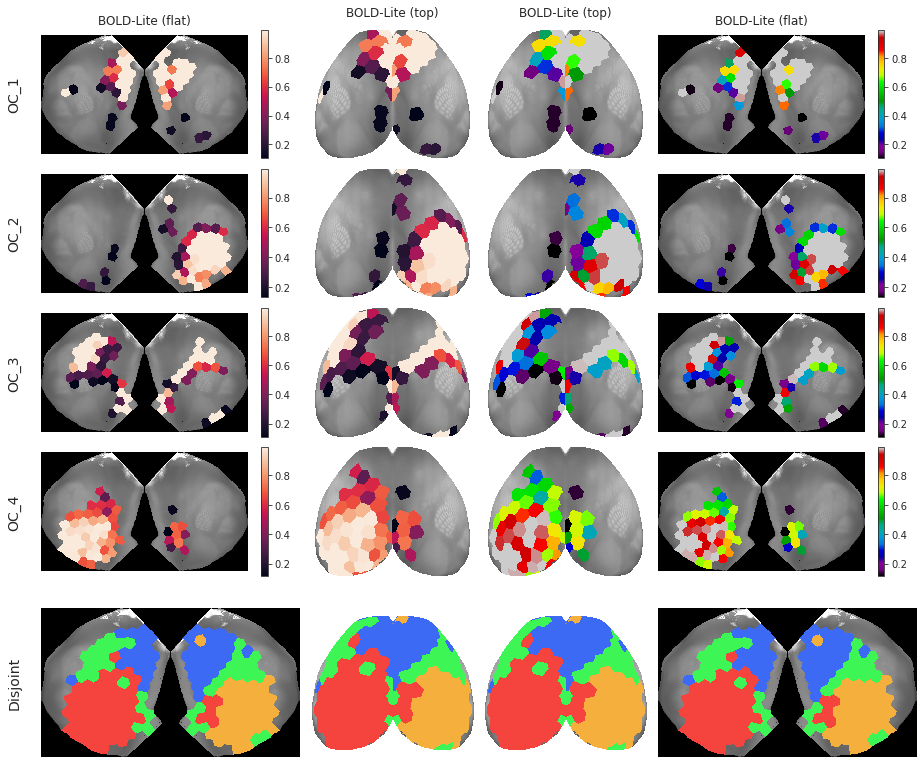

In [15]:
pi = run['pi'][list(mapping.values())]
_ = sv.show(sv.project_vec(pi))

In [47]:
mapping = sv.perms[sv.perc][name]
mapping_inv = {j: i for i, j in mapping.items()}

mapping, mapping_inv

({0: 2, 1: 0, 2: 1, 3: 3}, {2: 0, 0: 1, 1: 2, 3: 3})

In [52]:
np.argmax(run['pi'], 0)

array([2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 1, 1,
       1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 3, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 2, 2, 2, 1, 3, 3, 1, 2, 1, 1, 3, 3, 3, 3, 3, 3, 2,
       0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0,
       0, 2, 0, 0, 3, 1, 3, 0, 0, 0, 2, 3, 0, 3, 3, 0, 2, 0, 1, 0, 3, 3,
       0, 3, 0, 3, 2, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
np.argmax(pi, axis=0)

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 0, 2, 2,
       2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 3, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 0, 0, 0, 2, 3, 3, 2, 0, 2, 2, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       1, 0, 1, 1, 3, 2, 3, 1, 1, 1, 0, 3, 1, 3, 3, 1, 0, 1, 2, 1, 3, 3,
       1, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
pi_all = []
for name, run in sv._runs[sv.perc].items():
    mapping = sv.perms[sv.perc][name]
    pi = run['pi'][list(mapping.values())]
    pi_all.append(np.expand_dims(pi, 0))
pi_all = np.concatenate(pi_all)
pi_all.shape

(500, 4, 174)

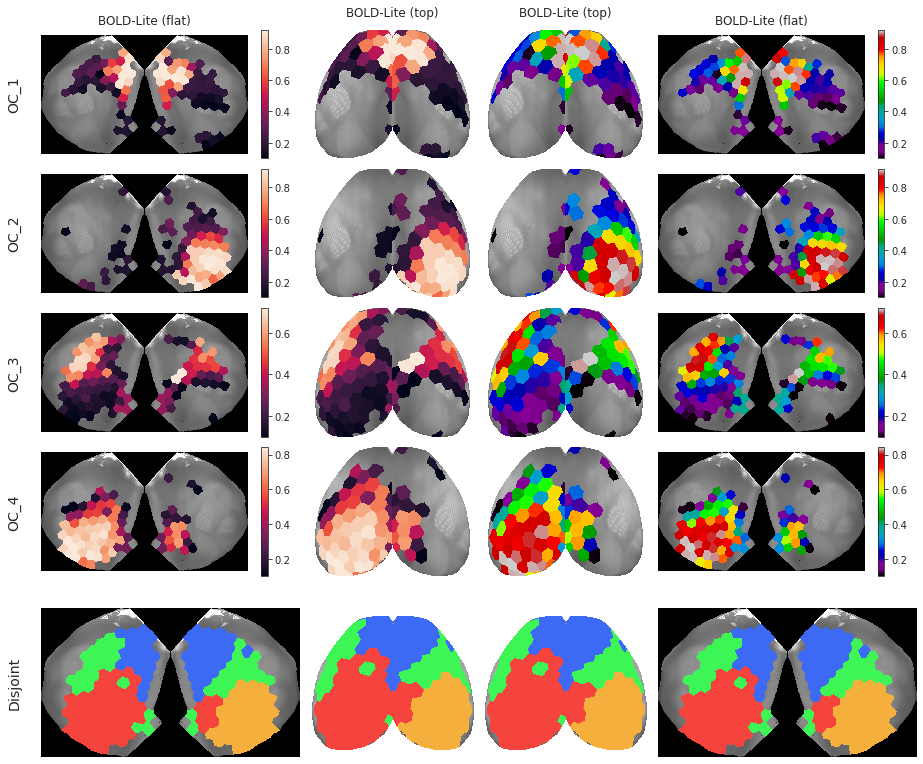

In [17]:
_ = sv.show(sv.project_vec(sv.pi))

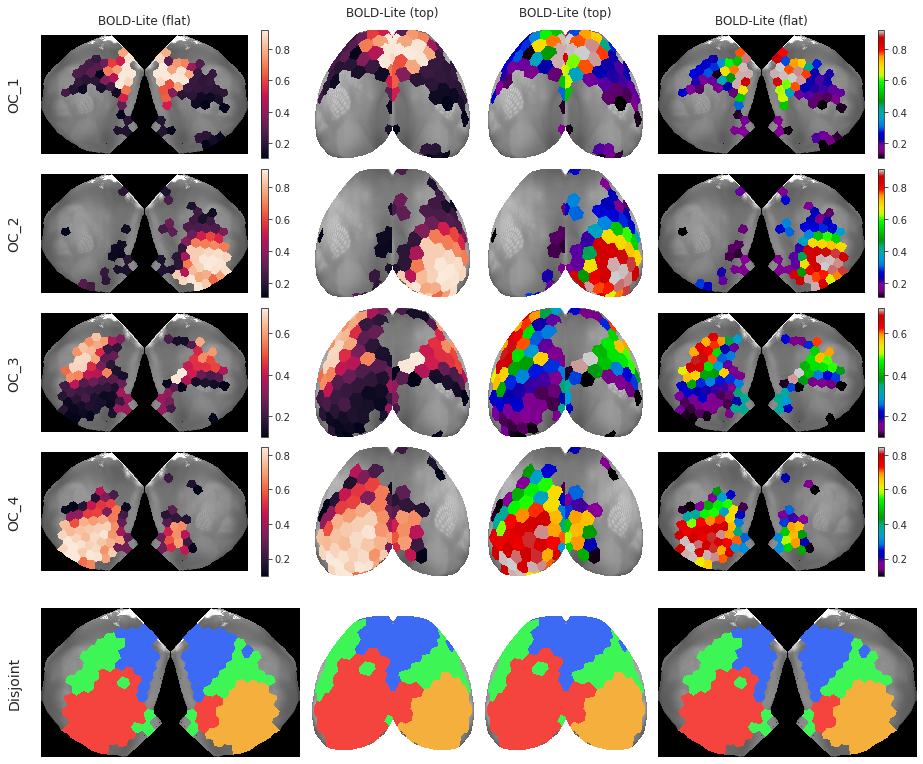

In [18]:
proj = sv.project_vec(pi_all.mean(0))
_ = sv.show(proj)

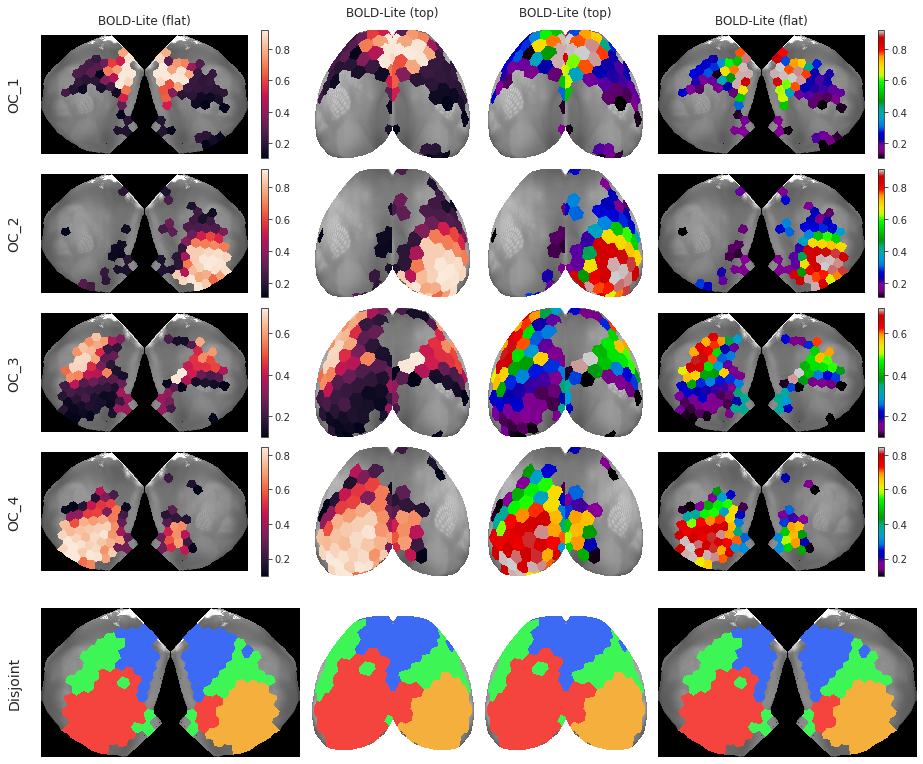

In [19]:
_ = sv.show(sv.project_vec(bn.nanmean(sv._cat_data(raw=False, which='pi'), 0)))

In [14]:
gam_all = []
for name, run in sv._runs[sv.perc].items():
    mapping = sv.perms[sv.perc][name]
    pi = run['gam'][list(mapping.values())]
    gam_all.append(np.expand_dims(pi, 0))
gam_all = np.concatenate(gam_all)
gam_all.shape

(500, 4, 174)

In [18]:
gam_all = np.where(gam_all.sum(1, keepdims=True) != 0, gam_all, np.nan)
_pi = gam_all / np.nansum(gam_all, 1, keepdims=True)

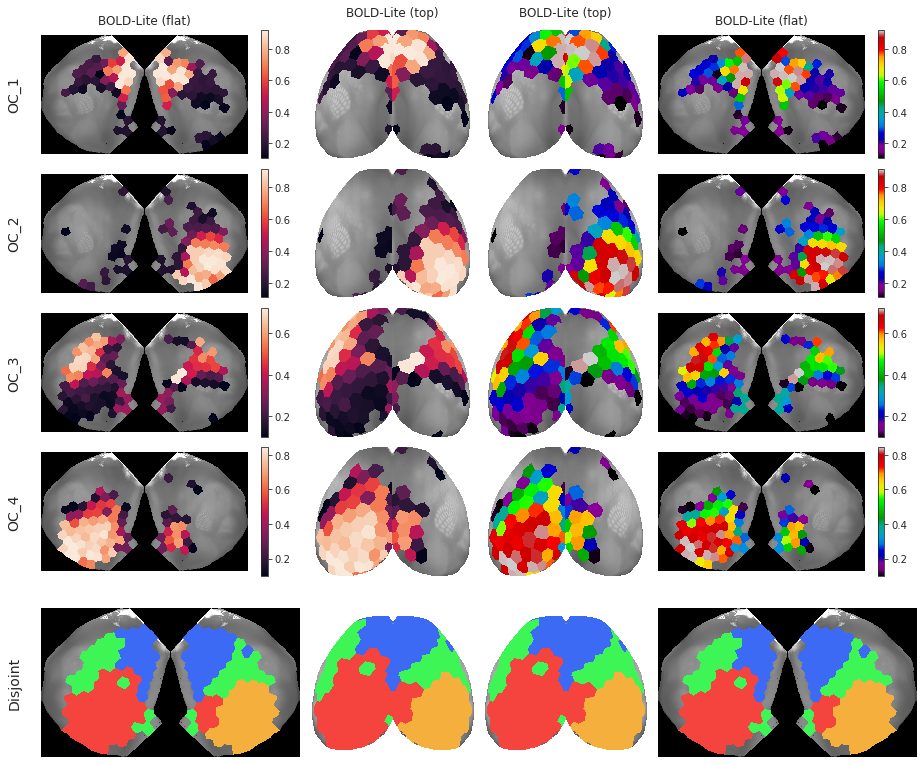

In [22]:
proj = sv.project_vec(bn.nanmean(_pi, 0))
_ = sv.show(proj)

In [14]:
for name, run in sv._runs[sv.perc].items():
    cond = list(np.argmax(run['pi'], 0)) == list(run['partition_sv'].values())
    if not cond:
        print(name)